<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/E533_DLS_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

P2: Variational Autoencoders on Poor Sevens 

In [1]:
# Reference: 
# https://www.tensorflow.org/tutorials/generative/cvae
# https://keras.io/examples/generative/vae/
# https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example

In [66]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model
import matplotlib.pyplot as plt
import librosa
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
import gzip
import time
import pickle
import random
from IPython import display

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
train_path = '/content/drive/MyDrive/DLS_DATA/assign_5/hw5_tr7.pkl'
test_path = '/content/drive/MyDrive/DLS_DATA/assign_5/hw5_te7.pkl'

In [113]:
with open(train_path, 'rb') as f:
    x_train = pickle.load(f)

In [114]:
with open(test_path, 'rb') as f:
    x_test = pickle.load(f)

In [115]:
print("Training Data Shape:",x_train.shape)
print("Testing Data Shape:",x_test.shape)

Training Data Shape: (6265, 28, 28)
Testing Data Shape: (1028, 28, 28)


In [116]:
x_train = x_train
x_test = x_test

In [117]:
train_size = 6265
batch_size = 32
test_size = 1028

In [118]:
class parameterize(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [119]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(1024, activation="gelu")(x),
x = layers.Dense(1024, activation="gelu")(x[0]),
x = layers.Dense(1024, activation="gelu")(x[0]),
x = layers.Dense(1024, activation="gelu")(x[0]),
z_mean = layers.Dense(latent_dim, name="z_mean")(x[0])
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x[0])
z = parameterize()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_22 (Flatten)           (None, 784)          0           ['input_34[0][0]']               
                                                                                                  
 dense_151 (Dense)              (None, 1024)         803840      ['flatten_22[0][0]']             
                                                                                                  
 dense_152 (Dense)              (None, 1024)         1049600     ['dense_151[0][0]']              
                                                                                            

In [120]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(1024, activation="gelu")(latent_inputs),
x = layers.Dense(1024, activation="gelu")(x[0]),
x = layers.Dense(1024, activation="gelu")(x[0]),
x = layers.Dense(1024, activation="gelu")(x[0]),
decoder_outputs = layers.Dense(784, activation="sigmoid")(x[0])
outputs = keras.layers.Reshape(target_shape=(28,28,1),input_shape=(784,))(decoder_outputs)
decoder = keras.Model(latent_inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_155 (Dense)           (None, 1024)              5120      
                                                                 
 dense_156 (Dense)           (None, 1024)              1049600   
                                                                 
 dense_157 (Dense)           (None, 1024)              1049600   
                                                                 
 dense_158 (Dense)           (None, 1024)              1049600   
                                                                 
 dense_159 (Dense)           (None, 784)               803600    
                                                                 
 reshape_9 (Reshape)         (None, 28, 28, 1)         0   

In [121]:
class VAE(tf.keras.Model):
    def __init__(self, encoder,decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")
        self.val_reconstruction_loss_tracker = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.val_kl_loss_tracker = keras.metrics.Mean(name="val_kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_kl_loss_tracker
        ]
    
    def compute_loss(self, x):
        mean,logvar,z = self.encoder(x)
        x_logit = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x, x_logit), axis=(1, 2)
                )
            )
        kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        return reconstruction_loss,kl_loss,total_loss
      
    def test_step(self,x):
        reconstruction_loss,kl_loss,loss = self.compute_loss(x)
        self.val_kl_loss_tracker.update_state(kl_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_total_loss_tracker.update_state(loss)

        return {
              "val_loss": self.total_loss_tracker.result(),
              "val_reconstruction_loss": self.reconstruction_loss_tracker.result(),
              "val_kl_loss": self.kl_loss_tracker.result(),
          }

    def train_step(self,x):
        with tf.GradientTape() as tape:
            reconstruction_loss,kl_loss,loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.total_loss_tracker.update_state(loss)

        return {
              "loss": self.total_loss_tracker.result(),
              "reconstruction_loss": self.reconstruction_loss_tracker.result(),
              "kl_loss": self.kl_loss_tracker.result(),
          }

In [122]:
epochs = 10
latent_dim = 4

In [123]:
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")

In [124]:
vae = VAE(encoder,decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(
    mnist_digits,
    batch_size=32,
    epochs=epochs
)

Epoch 1/10
228/228 [==============================] - 30s 123ms/step - loss: 240.1464 - reconstruction_loss: 185.5958 - kl_loss: 5.0578
Epoch 2/10
228/228 [==============================] - 26s 116ms/step - loss: 148.2927 - reconstruction_loss: 140.7891 - kl_loss: 4.7733
Epoch 3/10
228/228 [==============================] - 27s 119ms/step - loss: 136.5457 - reconstruction_loss: 126.4817 - kl_loss: 6.3112
Epoch 4/10
228/228 [==============================] - 27s 118ms/step - loss: 127.5612 - reconstruction_loss: 118.9410 - kl_loss: 6.9804
Epoch 5/10
228/228 [==============================] - 27s 117ms/step - loss: 122.3450 - reconstruction_loss: 115.9191 - kl_loss: 7.1916
Epoch 6/10
228/228 [==============================] - 30s 132ms/step - loss: 121.5907 - reconstruction_loss: 113.9596 - kl_loss: 7.3140
Epoch 7/10
228/228 [==============================] - 27s 119ms/step - loss: 120.4253 - reconstruction_loss: 112.6810 - kl_loss: 7.3843
Epoch 8/10
228/228 [============================

In [125]:
n = 10 # Number of images to reconstruct
K = 4 # Latent Vector Dimension

In [126]:
z_rand = tf.constant(np.random.normal(0,1,size=(n,K)),dtype=tf.float32)

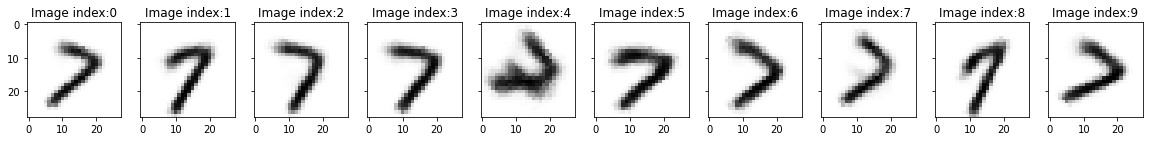

In [127]:
x_rand_recon = vae.decoder(z_rand)
x_rand_recon = tf.reshape(x_rand_recon,shape=(-1,28,28)).numpy()
fig, axes = plt.subplots(1,n, figsize=(20,20),sharex=True, sharey=True,subplot_kw=dict(aspect='equal'))

for idx in range(0,n):
    ax = axes[idx]
    img = x_rand_recon[idx,:,:]
    ax.imshow(img, cmap='gray_r')
    ax.set_title("Image index:"+str(idx))